In [14]:
import os
import jieba
import gensim
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# 加载停用词表和标点符号表，添加了LDA模型中，在每个主题都出现较多的词
with open('../cn_stopwords.txt', 'r', encoding='utf8') as f:
    stopwords = set(f.read().splitlines())
stopwords.add('道')
stopwords.add('说')
stopwords.add('曰')
stopwords.add('说道')
stopwords.add('□')
with open('../cn_punctuation.txt', 'r', encoding='utf8') as f:
    punctuation = set(f.read().splitlines())
punctuation.add(' ')
punctuation.add('　')


# 将字符串分割成词（mode='w'）或字（mode='c'）序列
def get_token(str, mode='c'):
    if mode == 'c':
        tokens = [c for c in str if c not in punctuation and c not in stopwords]
    else:
        tokens = [word for word in jieba.cut(str) if word not in stopwords and word not in punctuation]
    return tokens

In [16]:
# 读取小说
novels=[]
novel_labels=[]
novel_length=[]
for filename in os.listdir('../text'):
    novel_labels.append(filename[:-4])
    with open(os.path.join('../text', filename), 'r', encoding='gb18030') as f:
        novel = f.read()
        novels.append(novel.splitlines())
    novel_length.append(len(novels[-1]))
    print(novel_labels[-1],novel_length[-1])
n_label=len(novel_labels)
print('小说数量：',n_label)

三十三剑客图 83
书剑恩仇录 1231
侠客行 3642
倚天屠龙记 5987
天龙八部 9594
射雕英雄传 10602
白马啸西风 2367
碧血剑 1626
神雕侠侣 2009
笑傲江湖 4287
越女剑 559
连城诀 2440
雪山飞狐 1155
飞狐外传 1630
鸳鸯刀 1036
鹿鼎记 11566
小说数量： 16


In [17]:
# 将小说分段，并筛选可用的段落
def get_paras(mode='w'):
    paras=[] # paragraph
    para_labels=[]
    for i_novel in range(n_label): # 遍历小说
        novel=novels[i_novel]
        for para in novel: # 遍历段落
            tokens=get_token(para, mode) # 得到字词序列
            if len(tokens)<=500:
                continue
            paras.append(tokens)
            para_labels.append(novel_labels[i_novel])

    if len(paras)>200: # 均匀采样
        step = len(paras)//200
        paras=paras[::step]
        para_labels=para_labels[::step]

    return paras,para_labels

In [18]:
# 观察所得段落的分布情况
def show_para_length(paras,para_labels):
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 每部小说的有效段落数量
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    para_label_counts = {}
    for item in para_labels:
        para_label_counts[item] = para_label_counts.get(item, 0) + 1
    plt.bar(para_label_counts.keys(),para_label_counts.values())
    plt.setp(plt.gca().get_xticklabels(), ha='right')
    plt.show()
    print('有效段落数量',len(para_labels),', 涉及小说共',len(para_label_counts))
    
    # 段落长度分布
    l=[len(para) for para in paras]
    plt.title('段落长度分布')
    plt.hist(l,bins=100)
    plt.show()
    print('总token数',sum(l))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\vrlab9\AppData\Local\Temp\jieba.cache
Loading model cost 0.534 seconds.
Prefix dict has been built successfully.


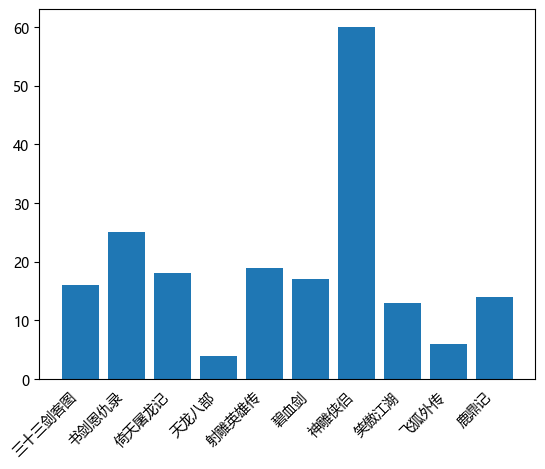

有效段落数量 192 , 涉及小说共 10


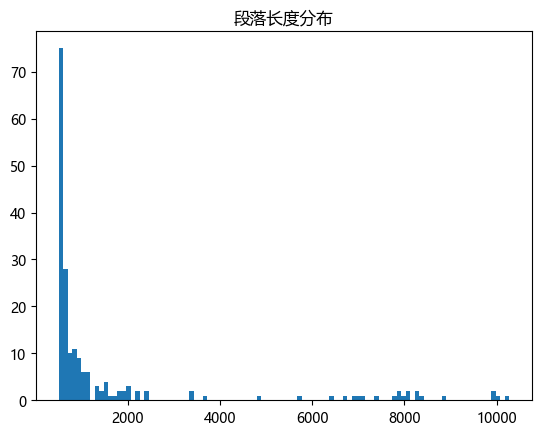

总token数 320475


In [19]:
paras,para_labels=get_paras(mode='w')
show_para_length(paras,para_labels)
dictionary = gensim.corpora.Dictionary(paras)
bows = [dictionary.doc2bow(para) for para in paras]

In [20]:
def show_Ntopics_model(start=10,stop=50,step=5):
    coherences=[]
    log_perplexities=[]
    x=list(range(start,stop,step))
    for num_topics in x:
        lda_model = gensim.models.LdaModel(bows, num_topics=num_topics, id2word=dictionary,iterations=100)
        
        log_perplexities.append(lda_model.log_perplexity(bows)) # 困惑度的对数 越低越好
        coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=paras, dictionary=dictionary, coherence='c_v')
        coherences.append(coherence_model_lda.get_coherence())# 一致性 越高越好
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x, coherences, 'r-')
    ax2.plot(x, log_perplexities, 'b-')
    ax1.set_xlabel('n_topics')
    ax1.set_ylabel('coherence', color='r')
    ax2.set_ylabel('log_perplexities', color='b')
    plt.show()


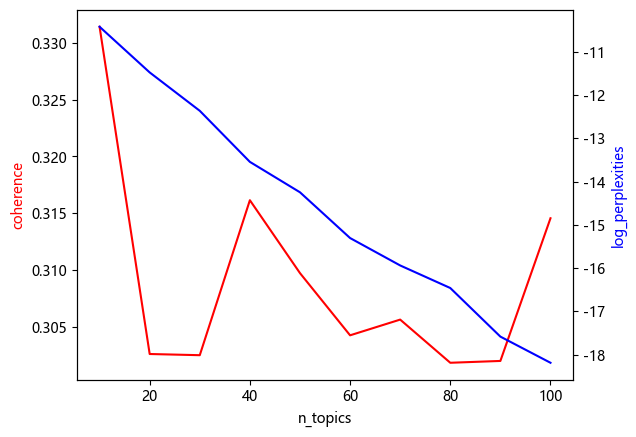

In [21]:
show_Ntopics_model(10,101,10)

In [32]:
N_topics=10
lda_model = gensim.models.LdaModel(bows, num_topics=N_topics, id2word=dictionary,iterations=1000)

In [33]:
# 将每个段落表示为主题分布向量
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(para_labels)
X = []
for paragraph in paras:
    # 将段落转换为词袋表示法
    bow_vector = dictionary.doc2bow(paragraph)
    # 使用LDA模型将段落表示为主题分布向量
    lda_vector = lda_model[bow_vector]
    # 将主题分布向量转换为稠密向量
    sparse_vector = list(zip(*lda_vector))
    dense_vector = np.zeros([N_topics])
    dense_vector[list(sparse_vector[0])]=sparse_vector[1]
    X.append(dense_vector)
X=np.array(X)
X.shape,y.shape

((192, 10), (192,))

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# 训练模型
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
# top1
y_pred = model.predict(X_test)

# top1准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Top-1 Accuracy: {accuracy:.4f}')

Top-1 Accuracy: 0.4000


In [45]:
# 获取预测概率
y_proba = model.predict_proba(X_test)

# 获取前5个最大概率的类别索引
top_5_idx = np.argsort(y_proba, axis=1)[:,-5:]

# 计算top-5分类准确率
accuracy = np.mean([y_test[i] in top_5_idx[i] for i in range(len(y_test))])
print("Top-5 Accuracy: %.2f%%" % (accuracy * 100.0))

Top-5 Accuracy: 90.00%
